# Architecture Autoencoder
Train an autoencoder then test it with a view samples to see the reconstruction

In [1]:
import matplotlib.pyplot as matPlt
import numpy as np

import tensorflow as tf
import keras
from keras import layers
from tqdm.keras import TqdmCallback

import rasterio

import junodch_utils_read_img as utils

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])


Tiles: 139113


In [3]:
trainMask = dataRadiance>0
lightCoords = dataCoords[trainMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])

Tiles: 139113
Light Tile: 689


#### Fetch images

In [4]:
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, lightCoords, res=64)
print(trainData.shape)

(689, 64, 64, 3)


# Autoencoder
Use adam optimizer unchanged, mse loss and relu activation.  
The image is reduce to 8x8 in the encoded format

In [5]:
# Input encoder
input_shape = trainData.shape[1:]

optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = lambda x: tf.keras.activations.relu(x, max_value=255)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3)

autoencoder = keras.Sequential([
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu', name='displayable_encoder'),

  layers.Flatten(name='encoder'),
  layers.Reshape(target_shape=(8,8,16)),

  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),

  layers.Conv2DTranspose(3, (3,3), 2, padding='same', activation='sigmoid', name='decoder'),
])

autoencoder.compile(optimizer=optimizer, loss=lossFunction)

print('Encoder shape:',autoencoder.get_layer('encoder').output_shape)

result = autoencoder.fit(trainData, trainData,
                          epochs=50,
                          batch_size=2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[
                            TqdmCallback(verbose=1), # Concise display progression
                            earlyStop,
                          ],
                        )


Encoder shape: (None, 1024)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 displayable_encoder (Conv2D  (None, 8, 8, 16)         4624      
 )                                                               
                                                                 
 encoder (Flatten)           (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       4640      
 nspose)                                                

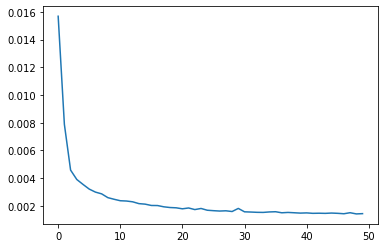

In [8]:
matPlt.plot(result.history['loss'][:], label='Training')
autoencoder.summary()

## Validation and test

Test display some tiles
Original data: (40, 64, 64, 3)


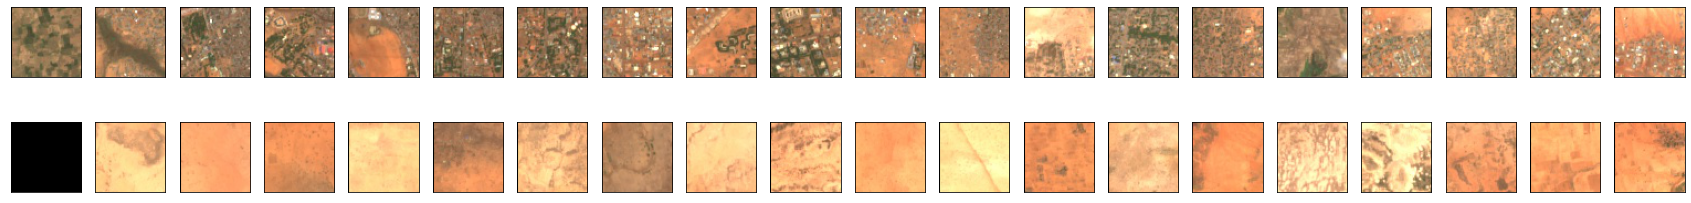

2/2 [==============================] - 0s 15ms/step
Output data: (40, 64, 64, 3)


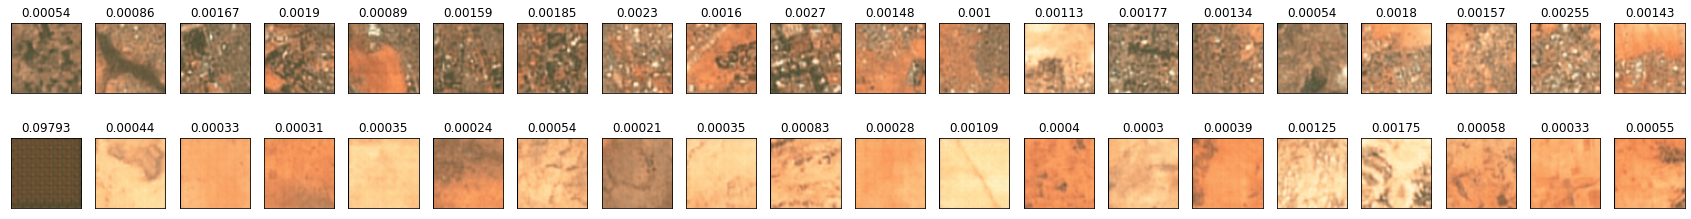

In [7]:
print("Test display some tiles")

indexesTest = [*np.argwhere(trainMask)[100:600:25].flatten(), *range(0,100000,5000)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.coordsToImgsFormated(f, dataCoords[indexesTest], res=64)

utils.displayAutoEncoderResults(autoencoder, dataTest, showDetail=0, precision=5)

In [ ]:
autoencoder.save('model/autoencoder_64px_encoder_1024')